In [1]:
import random
import matplotlib.pyplot as plt
from matplotlib import animation
# %matplotlib notebook
import math
import copy
import csv
import pandas as pd

In [2]:
#constants definition
GRID_SIZE = 100 # length and width of the grid
N = 1 #number of agents
RULES =  [(1,1), (-1,0)]#rules for the agents
STATES = len(RULES) #number of states
PROBABILITIES = 0 #probability of changing state
ITERS_PER_FRAME = 100 #number of iterations per frame
ITERS_TOTAL = 20000 #total number of iterations, typically must be > 10000 for interesting results
FPS = 15 #frames per second
LOOPS = True #whether or not the grid loops around
DO_ANIMATION = True  #whether or not to do the animation, its expensive
ASYNCHRONOUS = True #whether or not to do asynchronous updating ***SLOW IF FALSE***
RANDOM_INIT = False #whether or not to initialize the grid randomly
CHAOS_ANTS = 0 #percentage of ants that have random rules

REGENERATE_DATA = False



In [3]:
def make_empty_grid(grid_size):
    return [[0 for i in range(grid_size)] for j in range(grid_size)]

def make_random_grid(grid_size):
    l = []
    for i in range(grid_size):
        l.append([])
        for j in range(grid_size):
            num = random.randint(1,100)
            if num <= PROBABILITIES*100:
                l[i].append(random.randint(1, STATES-1))
            else:
                l[i].append(0)
    return l

def count_non_zero(grid):
    count = 0
    for i in range(len(grid)):
        for j in range(len(grid)):
            if grid[i][j] != 0:
                count += 1
    return count

def get_entropy(grid):
    #get the entropy of the grid (Wolfram's definition)
    #entropy = -sum(p(x1-xn)*log(p(x1-xn)))
    #p(x) = number of times x occurs / total number of elements
    #x1-xn are the states
    #p(x1-xn) is the probability of the state x1-xn occurring
    #log is base 2
    entropy = 0
    total = len(grid)**2
    for i in range(STATES):
        count = 0
        for j in range(len(grid)):
            for k in range(len(grid)):
                if grid[j][k] == i:
                    count += 1
        p = count/total
        # p = PROBABILITIES[i]/(count/total)
        if p != 0:
            entropy += -p*math.log(p, 2)
    return entropy

def get_mutual_information(grid, grid2):
    #get the mutual information between two grids
    #mutual information = sum(p(x,y)*log(p(x,y)/(p(x)*p(y))))
    #p(x,y) = number of times x and y occur / total number of elements
    #p(x) = number of times x occurs / total number of elements
    #p(y) = number of times y occurs / total number of elements
    #x and y are the states
    mutual_information = 0
    total = len(grid)**2
    for i in range(STATES):
        for j in range(STATES):
            count = 0
            for k in range(len(grid)):
                for l in range(len(grid)):
                    if grid[k][l] == i and grid2[k][l] == j:
                        count += 1
            p = count/total
            if p != 0:
                mutual_information += p*math.log(p/((get_sums(grid)[i]/total)*(get_sums(grid2)[j]/total)), 2)
    return mutual_information

def get_sums(grid):
    #get the sum of each state in the grid
    sums = []
    for i in range(STATES):
        sums.append(0)
    for i in range(len(grid)):
        for j in range(len(grid)):
            sums[grid[i][j]] += 1
    return sums

In [4]:
class Ant:
    def __init__(self, grid_size, rules, random_start = False):
        if random_start:
            self.x = random.randint(0,grid_size-1)
            self.y = random.randint(0,grid_size-1)
        else:
            self.x = GRID_SIZE//2
            self.y = GRID_SIZE//2
        self.direction = 0 #0 is up, 1 is right, 2 is down, 3 is left
        self.rules = rules #should be a list of tuples of the form [(direction_change, new_state), ...)] where the index of the tuple is the state of the tile the ant is on
        self.grid_size = grid_size

    def update(self, grid, grid2 = None):
        #update the ant's position and direction based on the rules
        #first get the state of the tile the ant is on
        state = grid[self.y][self.x]
        #update the direction
        self.direction = (self.direction + self.rules[state][0]) % 4

        #update the state of the tile
        if grid2 != None: #if not asynch, don't change grid yet
            grid2[self.y][self.x] = self.rules[state][1]
        else:
            grid[self.y][self.x] = self.rules[state][1]

        #update the ant's position
        if self.direction == 0:
            self.y -= 1
        elif self.direction == 1:
            self.x += 1
        elif self.direction == 2:
            self.y += 1
        elif self.direction == 3:
            self.x -= 1
        
        if LOOPS:
            if self.is_off_grid(self.grid_size):
                self.x %= self.grid_size
                self.y %= self.grid_size

        if grid2 != None:
            return grid2

    def is_off_grid(self, grid_size):
        if self.x < 0 or self.x >= grid_size or self.y < 0 or self.y >= grid_size:
            return True
        return False

def gen_ants():
    ants = []
    for i in range(N):
        p = random.randint(1,100)
        if p < CHAOS_ANTS*100:
            rules = [(random.randint(0,3), random.randint(0,STATES-1)) for _ in range(STATES)] #for each state, create a random transition rule
        else:
            rules = RULES
        ants.append(Ant(GRID_SIZE, rules, RANDOM_INIT))
    return ants

def merge_grids(grid, ants):
    temp = copy.deepcopy(grid)

    #replace each ant's position with a STATES+1
    for ant in ants:
        temp[ant.y][ant.x] = STATES+1

    return temp


5 % done
10 % done
15 % done
20 % done
25 % done
30 % done
35 % done
40 % done
45 % done
50 % done
55 % done
60 % done
65 % done
70 % done
75 % done
80 % done
85 % done
90 % done
95 % done
100 % done


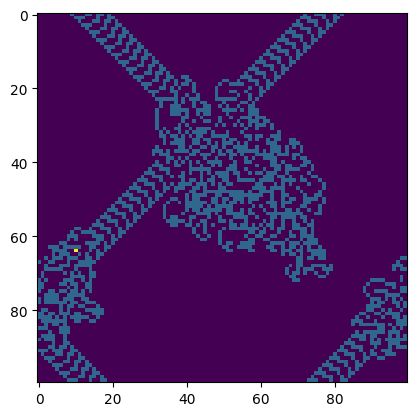

In [5]:
if True:
    # ants =  [Ant(GRID_SIZE, RULES, RANDOM_INIT) for _ in range(N)]
    ants = gen_ants()
    grid = make_random_grid(GRID_SIZE)
    grid2 = copy.deepcopy(grid)
    iterations = 0
    ims = []
    fig = plt.figure()
    entropies = []
    element_sums = []#list of the sums of the states of the grid
    mutual_info = []
    while iterations < ITERS_TOTAL:
        for i in range(ITERS_PER_FRAME):
            if not ASYNCHRONOUS:
                #if not asynchronous, update all the ants at once, then update the grid
                #so make a copy of the grid
                grid_copy = copy.deepcopy(grid)
            for ant in ants:
                if not ant.is_off_grid(GRID_SIZE):
                    if ASYNCHRONOUS:
                        ant.update(grid)
                    else:
                        grid_copy = ant.update(grid, grid_copy)
            if not ASYNCHRONOUS:
                grid = grid_copy
        iterations += ITERS_PER_FRAME
        
        entropies.append(get_entropy(grid))
        element_sums.append(get_sums(grid))
        mutual_info.append(get_mutual_information(grid, grid2))
        grid2 = copy.deepcopy(grid)

        if iterations % ITERS_PER_FRAME == 0 and DO_ANIMATION:
            merged_grid = merge_grids(grid, ants)
            ims.append((plt.imshow(merged_grid, animated=True),))
        if iterations % round(ITERS_TOTAL/100*5) == 0: #print progress every 1%
            print(round(iterations/ITERS_TOTAL*100), "% done")


    if DO_ANIMATION:
        #animate out saved grids
        im_ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=3000, blit=True)

        #save to gif using pillow
        im_ani.save("fun.gif", writer='pillow', fps=FPS)




In [6]:
if REGENERATE_DATA:  #only run this when we need to remake the visualizations  
    #graph entropy over time
    plt.figure()
    plt.plot(entropies)
    plt.xlabel("Iterations/ITERS_PER_FRAME")
    plt.ylabel("Entropy")
    plt.show()

    #plot the sums of each state over time on the same graph
    plt.figure()
    for i in range(STATES):
        plt.plot([x[i] for x in element_sums])
    plt.xlabel("Iterations/ITERS_PER_FRAME")
    plt.ylabel("Sum of each state")
    plt.show()

    #plot the mutual information over time
    plt.figure()
    plt.plot(mutual_info)
    plt.xlabel("Iterations/ITERS_PER_FRAME")
    plt.ylabel("Mutual Information")
    plt.show()





In [7]:
RULESETS = [
    [(1,1), (-1,0)],
    [(1,2), (-1,0), (2, 1)],
    [(1,2), (-1,0), (0, 1)],
    [(1,1), (0,2), (-1,3), (0,4), (1,5), (0,6), (-1,7), (0,0)],
    [(0,1), (1,2), (-1,3), (0,4), (0,5), (1,6), (1,7), (-1,0)]
]
NSETS = [1, 3, 10, 20]
PROBABILITIESSETS = [0, 0.05, 0.1, 0.5]
ASYNCHRONOUSSET = [True, False]
CHAOS_ANTS_SETS = [0, 0.1, 0.2, 0.5, 1]
NUM_RUNS = 3
if REGENERATE_DATA:    

    file_name = "data.csv"

    #run the simulation for all permutations of the above parameters
    #gathering data on the entropy, mutual information, and sums of each state
    #for each run, save the data to a csv file
    total = len(RULESETS)*len(NSETS)*len(PROBABILITIESSETS)*len(CHAOS_ANTS_SETS)*NUM_RUNS
    count = 0
    for i in range(NUM_RUNS):
        for rule in RULESETS:
            RULES = rule
            STATES = len(RULES)
            for n in NSETS:
                N = n
                for prob in PROBABILITIESSETS:
                    PROBABILITIES = prob
                    for chaos in CHAOS_ANTS_SETS:
                        CHAOS_ANTS = chaos
                        ants = gen_ants()
                        grid = make_random_grid(GRID_SIZE)
                        grid2 = copy.deepcopy(grid)
                        iterations = 0
                        ims = []
                        # fig = plt.figure()
                        entropies = []
                        element_sums = []#list of the sums of the states of the grid
                        mutual_info = []
                        while iterations < ITERS_TOTAL:
                            for i in range(ITERS_PER_FRAME):
                                if not ASYNCHRONOUS:
                                    #if not asynchronous, update all the ants at once, then update the grid
                                    #so make a copy of the grid
                                    grid_copy = copy.deepcopy(grid)
                                for ant in ants:
                                    if not ant.is_off_grid(GRID_SIZE):
                                        if ASYNCHRONOUS:
                                            ant.update(grid)
                                        else:
                                            grid_copy = ant.update(grid, grid_copy)
                                if not ASYNCHRONOUS:
                                    grid = grid_copy
                            iterations += ITERS_PER_FRAME
                            
                            entropies.append(get_entropy(grid))
                            element_sums.append(get_sums(grid))
                            mutual_info.append(get_mutual_information(grid, grid2))
                            grid2 = copy.deepcopy(grid)
                        #write data to file
                        with open(file_name, 'a') as f:
                            writer = csv.writer(f)
                            writer.writerow([RULES, STATES, N, PROBABILITIES, CHAOS_ANTS, entropies, element_sums, mutual_info])
                        count += 1
                        print(count, "/", total, " done")




In [8]:
#open csv file into pandas dataframe
file_name = "data.csv"
df = pd.read_csv(file_name, header=None)
df.columns = ["RULES", "STATES", "N", "PROBABILITIES", "CHAOS_ANTS", "ENTROPIES", "ELEMENT_SUMS", "MUTUAL_INFO"]

In [9]:
#I stored some of these things in an inconvenient way, so I'm going to fix that
#replace each rule value with an index matching the RULESETS list
#convert the list of rules in RULES to a string, and then do the same for the RULESETS list
#then find the index of the string in the list
#then replace the value in RULES with the index

STRRULES = []
for rule in RULESETS:
    #convert each rule to an identical string
    rule = str(rule)
    STRRULES.append(rule)

#replace each rule in RULES with the index of the rule in RULESETS
for i in range(len(df["RULES"])):
    rule = df["RULES"][i]
    rule = str(rule)
    df["RULES"][i] = STRRULES.index(rule)
    
    


#print the number of each value in the RULES column
print(df["RULES"].value_counts())

C:\Users\LagoonyToons\AppData\Local\Temp\ipykernel_85716\1179411478.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["RULES"][i] = STRRULES.index(rule)


0    240
1    240
2    240
3    240
4    240
Name: RULES, dtype: int64


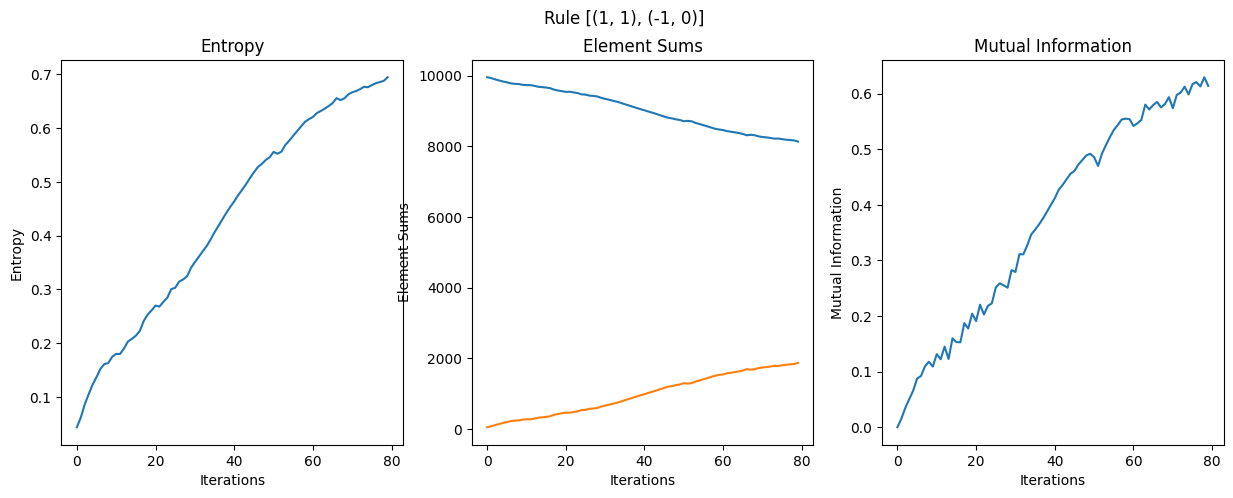

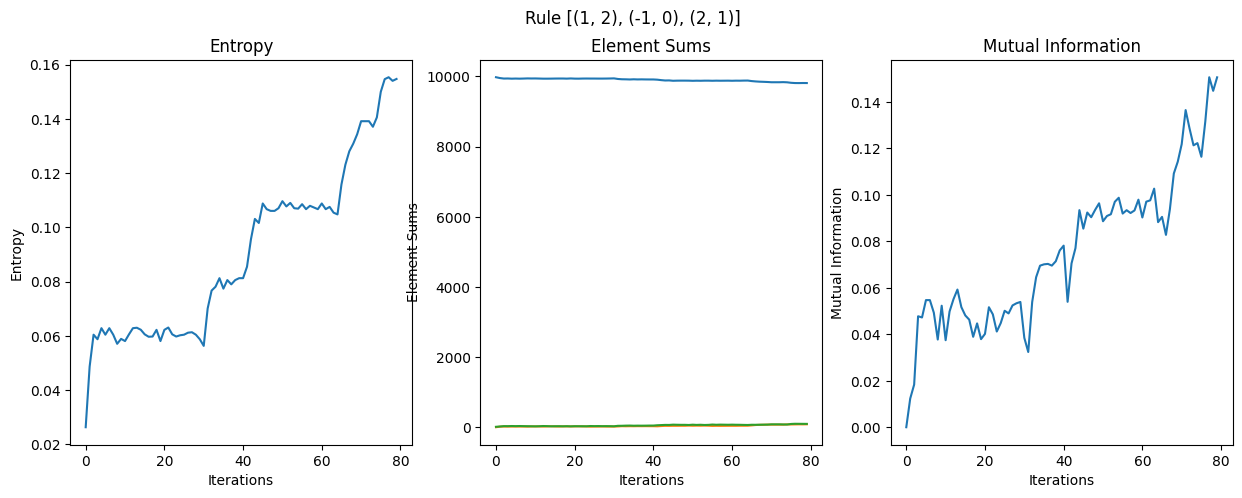

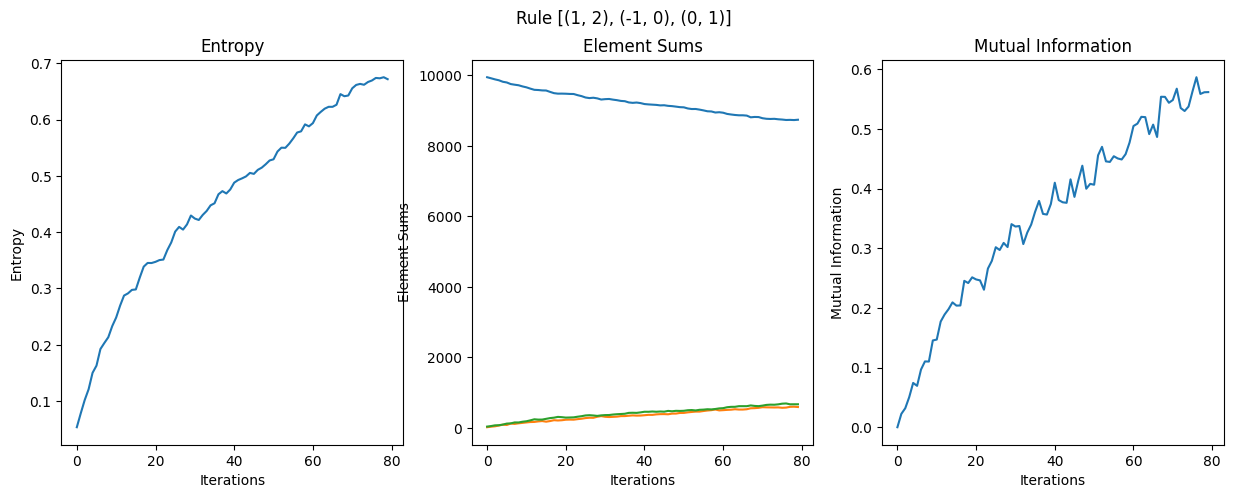

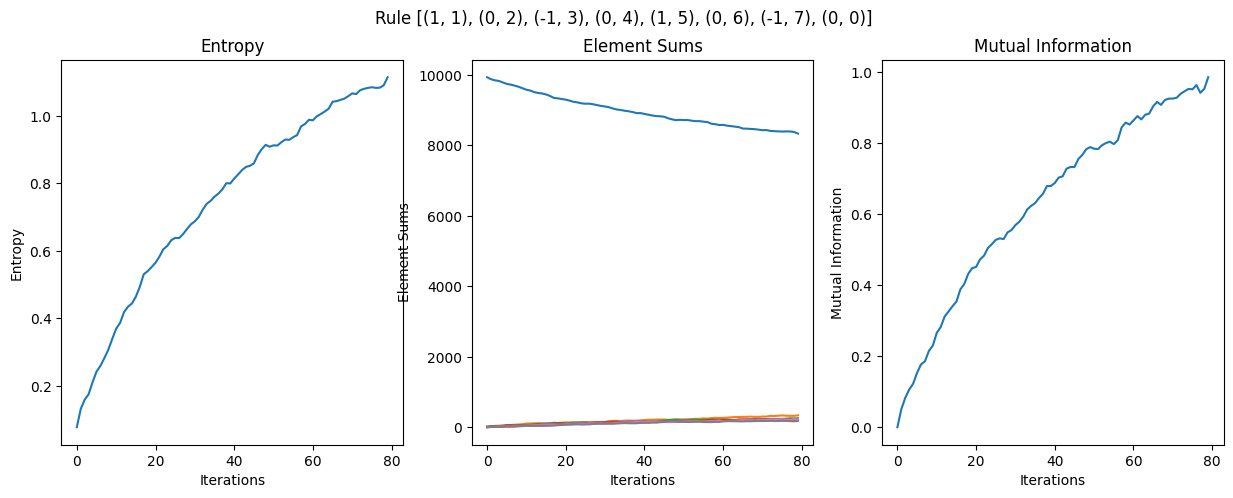

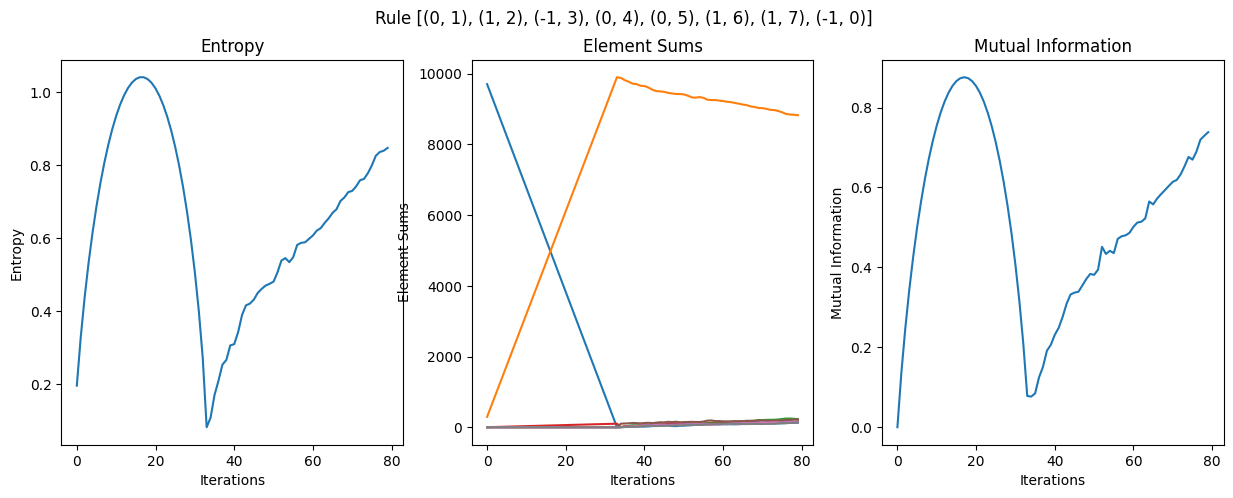

In [10]:
import numpy as np
import ast

# RULESETS = [
#         [(1,1), (-1,0)],
#         [(1,2), (-1,0), (2, 1)],
#         [(1,2), (-1,0), (0, 1)],
#         [(1,1), (0,2), (-1,3), (0,4), (1,5), (0,6), (-1,7), (0,0)],
#         [(0,1), (1,2), (-1,3), (0,4), (0,5), (1,6), (1,7), (-1,0)]
#     ]
#     NSETS = [1, 3, 10, 20]
#     PROBABILITIESSETS = [0, 0.05, 0.1, 0.5]
#     ASYNCHRONOUSSET = [True, False]
#     CHAOS_ANTS_SETS = [0, 0.1, 0.2, 0.5, 1]
#     NUM_RUNS = 3

#default is the first of each set above


# print(df.head())
def get_stats(data, n_val = 1, prob_val = 0, chaos_val = 0):

    #for each ruleset
    entropies = []
    element_sums = []
    mutual_info = []
    for ruleset in range(len(RULESETS)):
        temp_entropies = []
        temp_element_sums = []
        temp_mutual_info = []
        element_sums.append([])
        entropies.append([])
        mutual_info.append([])
        #average the entropies, element sums, and mutual information over all the 3 runs with the default values
        parsed_data = (df.loc[(df["RULES"] == ruleset) & (df["N"] == n_val) & (df["PROBABILITIES"] == prob_val) & (df["CHAOS_ANTS"] == chaos_val)])
        #we want to average entropies[0][0], entropies[1][0], entropies[2][0] then entropies[0][1], entropies[1][1], entropies[2][1] etc
        #so we need to iterate over the rows of parsed_data
        for i in range(len(parsed_data)):
            temp_entropies.append(ast.literal_eval(parsed_data["ENTROPIES"].iloc[i]))
            temp_element_sums.append(ast.literal_eval(parsed_data["ELEMENT_SUMS"].iloc[i]))
            temp_mutual_info.append(ast.literal_eval(parsed_data["MUTUAL_INFO"].iloc[i]))
            # print(temp_element_sums)
        for i in range(len(temp_entropies[0])):
            temp = []
            for j in range(len(temp_entropies)):
                temp.append(temp_entropies[j][i])
            entropies[-1].append(np.mean(temp))

        for i in range(len(temp_element_sums[0])): #for each snapshot
            element_sums[ruleset].append([]) #add new list to hold our state averages
            for j in range(len(temp_element_sums[0][i])): #for each state count
                added = 0
                for k in range(len(temp_element_sums)): #for each of the 3 runs
                    added += temp_element_sums[k][i][j]
                added /= len(temp_element_sums) #average the state counts
                element_sums[ruleset][-1].append(added) #add the average to the list of averages

        for i in range(len(temp_mutual_info[0])):
            temp = []
            for j in range(len(temp_mutual_info)):
                temp.append(temp_mutual_info[j][i])
            mutual_info[-1].append(np.mean(temp))
    return entropies, element_sums, mutual_info

# print(element_sums[4]) # should be a list of lists of ints
# print(len(element_sums[0]))
# print(len(element_sums))
# print("element sums: ", element_sums)
# print("entropies: ", entropies)
# print("mutual info: ", mutual_info)

#now for each ruleset graph the entropies, element sums, and mutual information, as we did above
def plot_stats(entropies, element_sums, mutual_info, amount = len(RULESETS)):
    for ruleset in range(amount):
        #make entropy, element sums, and mutual information as subplots of one figure
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("Rule " + str(RULESETS[ruleset]))
        axs[0].set_title("Entropy")
        axs[0].set_xlabel("Iterations")
        axs[0].set_ylabel("Entropy")
        axs[0].plot(entropies[ruleset])
        axs[1].set_title("Element Sums")
        axs[1].set_xlabel("Iterations")
        axs[1].set_ylabel("Element Sums")
        for i in range(len(element_sums[ruleset][0])):
            axs[1].plot([element_sums[ruleset][j][i] for j in range(len(element_sums[ruleset]))])
        axs[2].set_title("Mutual Information")
        axs[2].set_xlabel("Iterations")
        axs[2].set_ylabel("Mutual Information")
        axs[2].plot(mutual_info[ruleset])
        # plt.savefig("rule" + str(RULESETS[ruleset]) + "all.png")
        plt.show()

entropies, element_sums, mutual_info = get_stats(df)
plot_stats(entropies, element_sums, mutual_info)



    





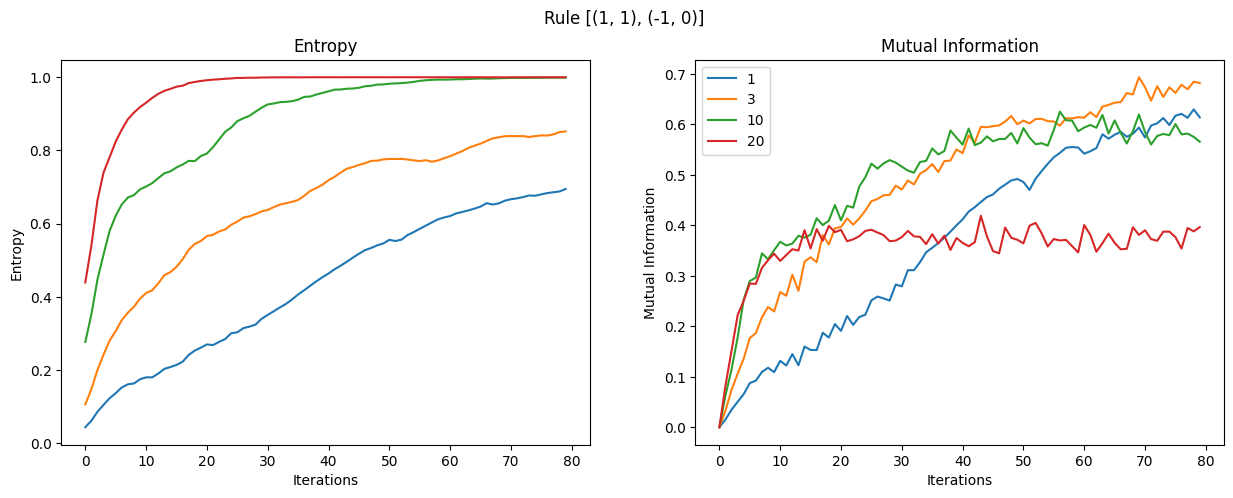

<Figure size 640x480 with 0 Axes>

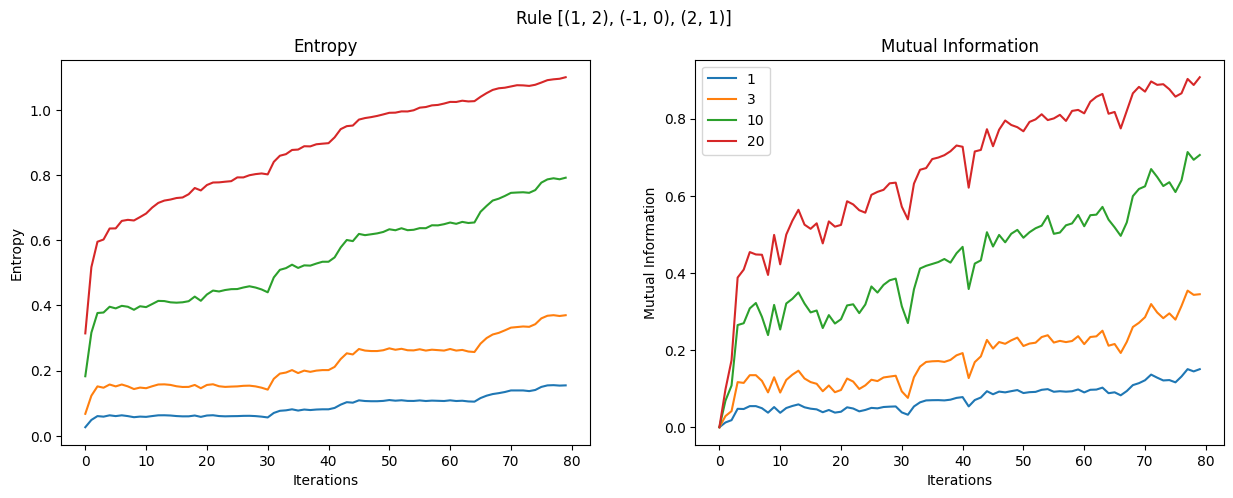

<Figure size 640x480 with 0 Axes>

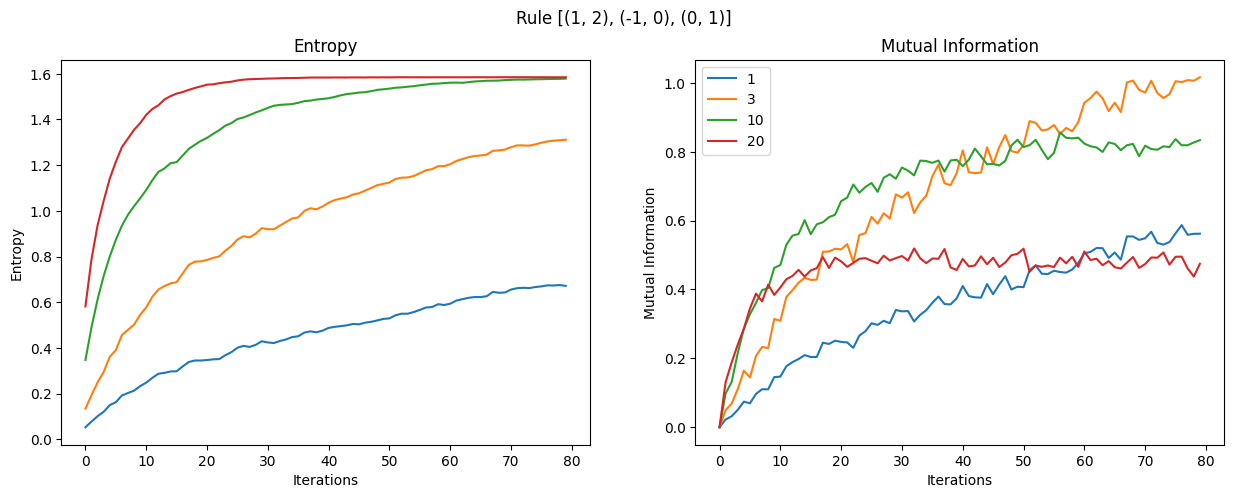

<Figure size 640x480 with 0 Axes>

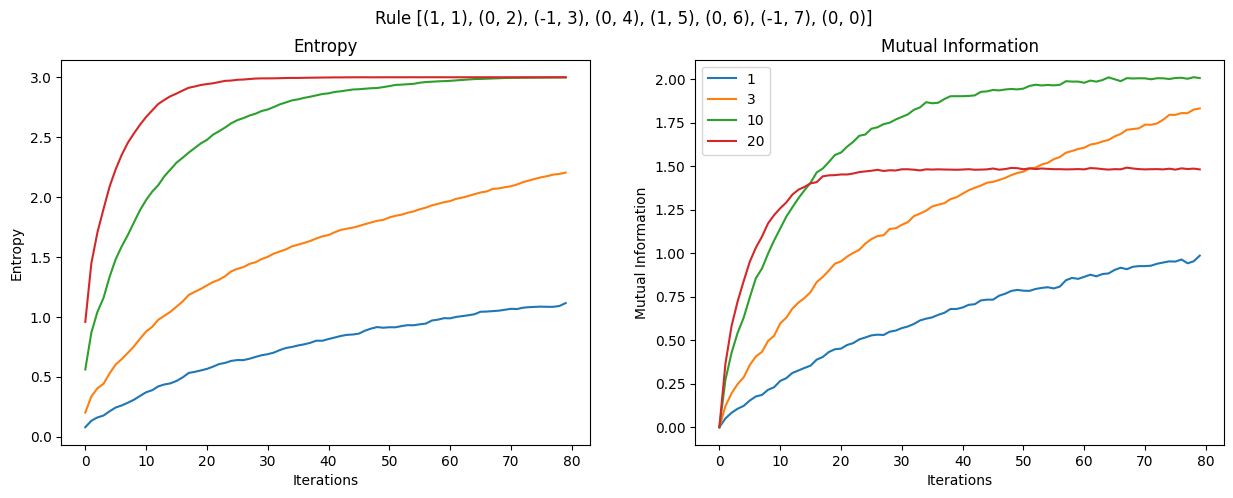

<Figure size 640x480 with 0 Axes>

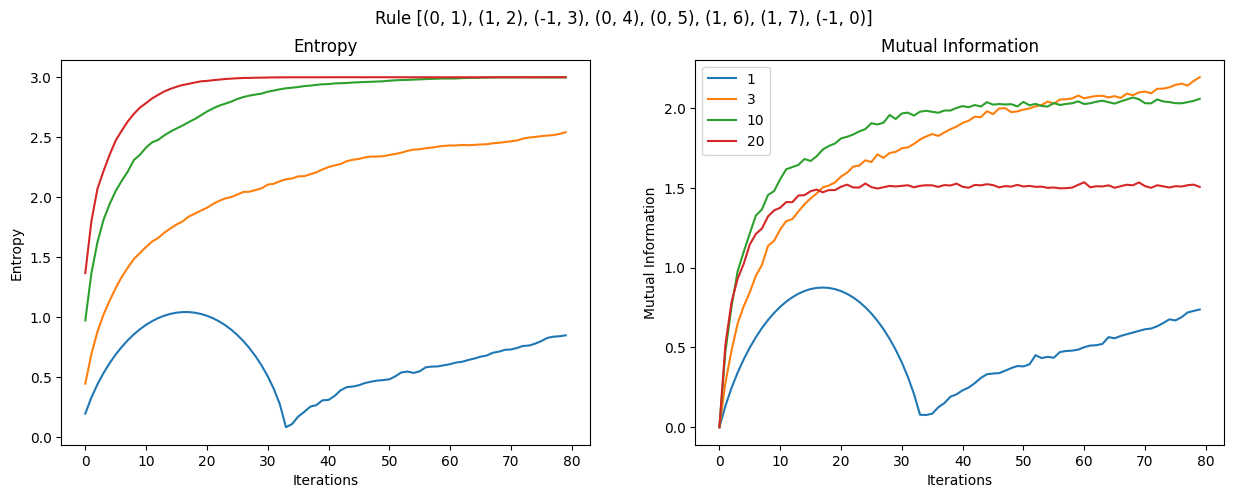

<Figure size 640x480 with 0 Axes>

In [11]:
#Now graph the entropies, element sums, and mutual information for each ruleset, for each of the 3 values of N
temp_ent  =[]
temp_elem = []
temp_mut  = []
for n in NSETS:
    entropies, element_sums, mutual_info = get_stats(df, n_val = n)
    temp_ent.append(entropies)
    temp_elem.append(element_sums)
    temp_mut.append(mutual_info)

#graph the entropies, element sums, and mutual information for each ruleset, for each of the values of N on the same graph
#we will just graph the basic ruleset for now
ruleset = 0
#make entropy, element sums, and mutual information as subplots of one figure
for ruleset in range(len(RULESETS)):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle("Rule " + str(RULESETS[ruleset]))
    axs[0].set_title("Entropy")
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel("Entropy")
    for i in range(len(temp_ent)):
        axs[0].plot(temp_ent[i][ruleset])
    axs[1].set_title("Mutual Information")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel("Mutual Information")
    for i in range(len(temp_mut)):
        axs[1].plot(temp_mut[i][ruleset])
    # plt.savefig("rule" + str(RULESETS[ruleset]) + "all.png")
    #add a legend for each of the values of N
    plt.legend(NSETS)
    plt.savefig("rule_" + str(RULESETS[ruleset]) + "_NSETS_all.png")
    plt.show()

    



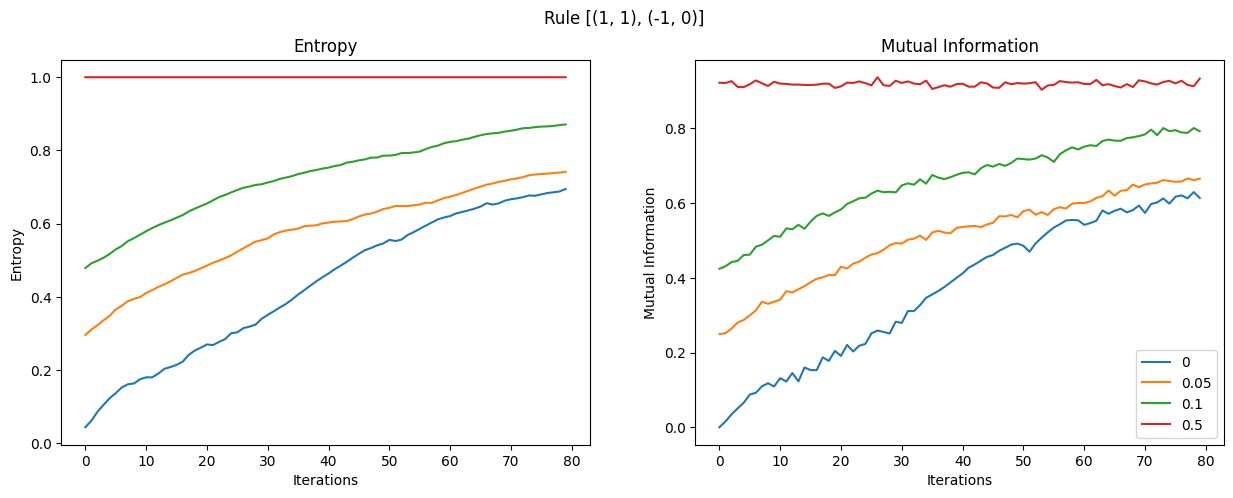

<Figure size 640x480 with 0 Axes>

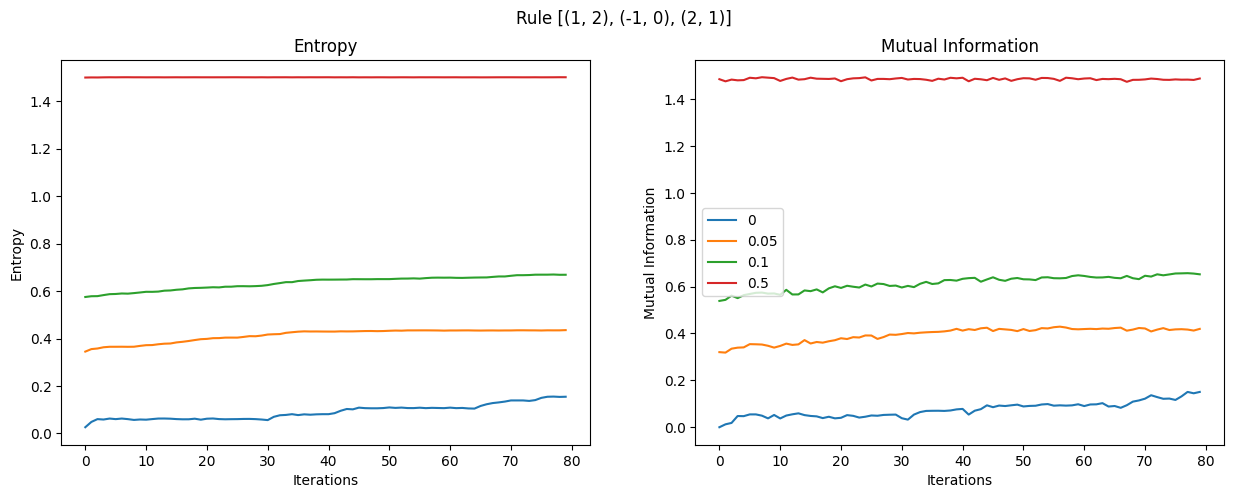

<Figure size 640x480 with 0 Axes>

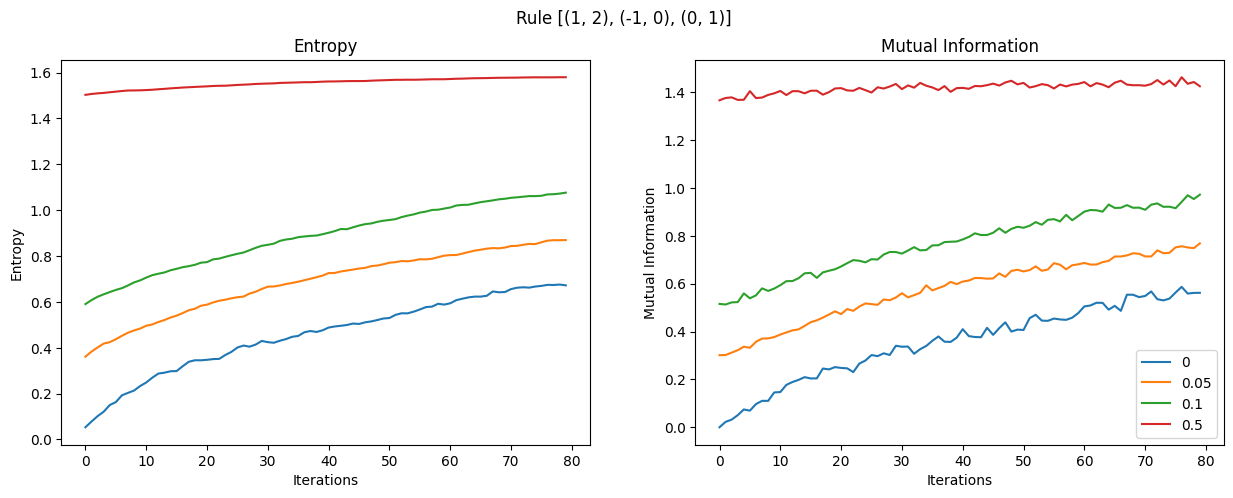

<Figure size 640x480 with 0 Axes>

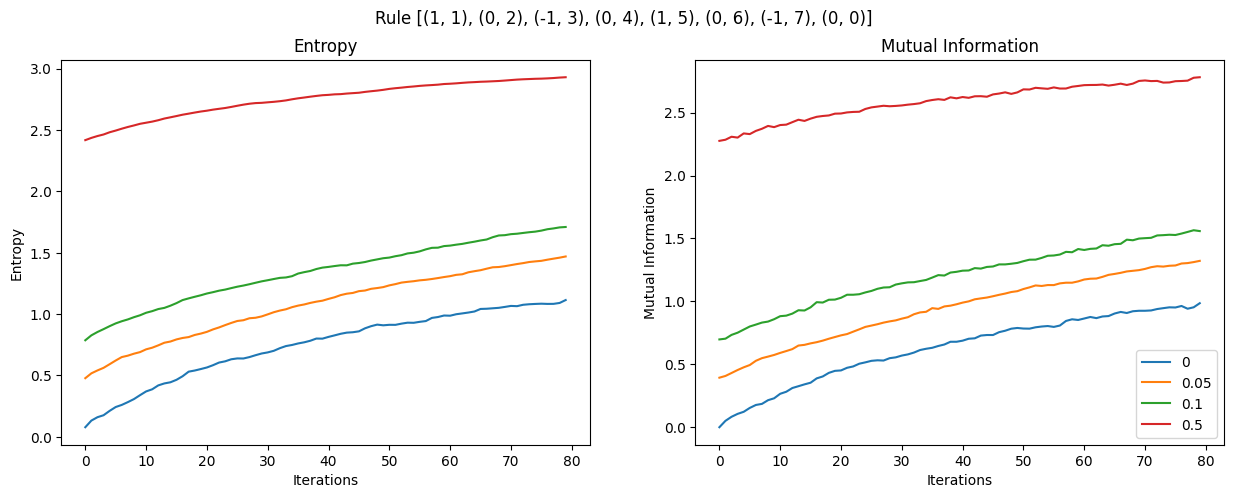

<Figure size 640x480 with 0 Axes>

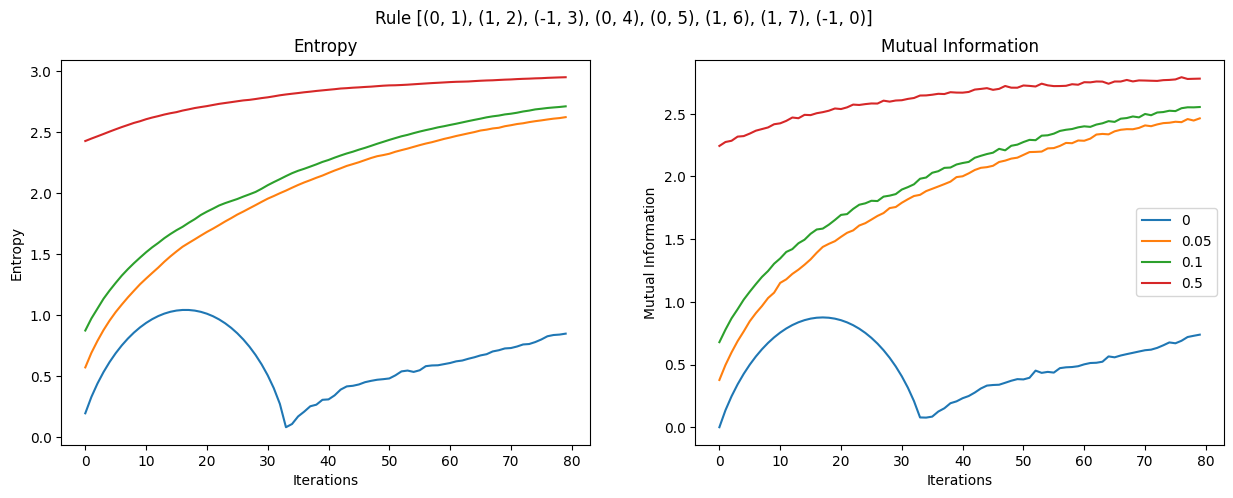

<Figure size 640x480 with 0 Axes>

In [12]:
temp_ent  =[]
temp_elem = []
temp_mut  = []
#now do it again for each of the values of P
for p in PROBABILITIESSETS:
    entropies, element_sums, mutual_info = get_stats(df, prob_val = p)
    temp_ent.append(entropies)
    temp_elem.append(element_sums)
    temp_mut.append(mutual_info)

#graph the entropies, element sums, and mutual information for each ruleset, for each of the values of P on the same graph
#we will just graph the basic ruleset for now
# ruleset = 0
# #make entropy, element sums, and mutual information as subplots of one figure
# fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# fig.suptitle("Rule " + str(RULESETS[ruleset]))
# axs[0].set_title("Entropy")
# axs[0].set_xlabel("Iterations")
# axs[0].set_ylabel("Entropy")
# for i in range(len(temp_ent)):
#     axs[0].plot(temp_ent[i][ruleset])
# axs[1].set_title("Mutual Information")
# axs[1].set_xlabel("Iterations")
# axs[1].set_ylabel("Mutual Information")
# for i in range(len(temp_mut)):
#     axs[1].plot(temp_mut[i][ruleset])
# # plt.savefig("rule" + str(RULESETS[ruleset]) + "all.png")
# #add a legend for each of the values of P
# plt.legend(PROBABILITIESSETS)
# plt.show()
for ruleset in range(len(RULESETS)):
    #make entropy, element sums, and mutual information as subplots of one figure
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle("Rule " + str(RULESETS[ruleset]))
    axs[0].set_title("Entropy")
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel("Entropy")
    for i in range(len(temp_ent)):
        axs[0].plot(temp_ent[i][ruleset])
    axs[1].set_title("Mutual Information")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel("Mutual Information")
    for i in range(len(temp_mut)):
        axs[1].plot(temp_mut[i][ruleset])
    # plt.savefig("rule" + str(RULESETS[ruleset]) + "all.png")
    #add a legend for each of the values of P
    plt.legend(PROBABILITIESSETS)
    plt.savefig("rule_" + str(RULESETS[ruleset]) + "_randomtiles_all.png")
    plt.show()


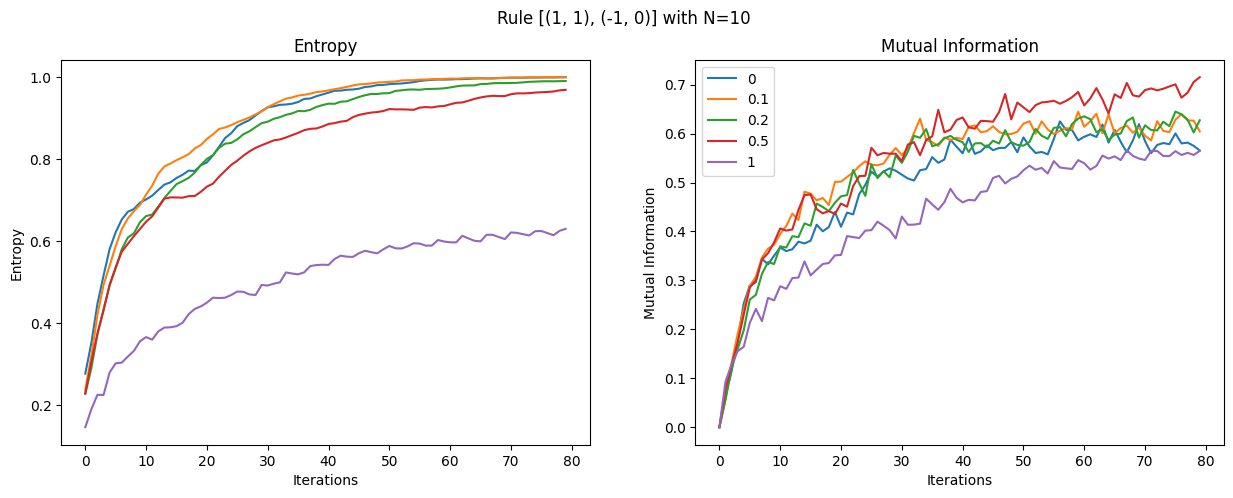

<Figure size 640x480 with 0 Axes>

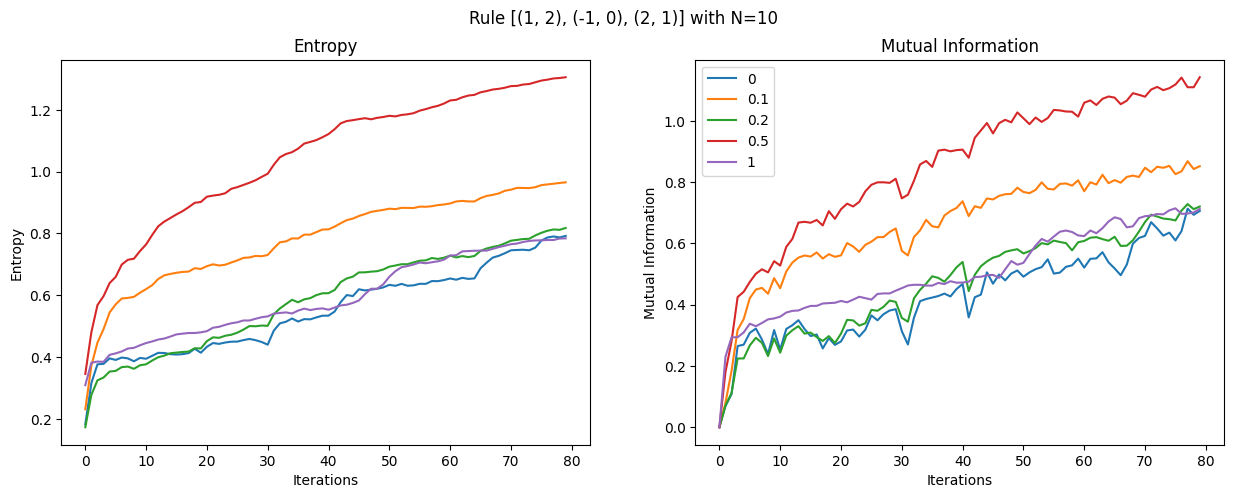

<Figure size 640x480 with 0 Axes>

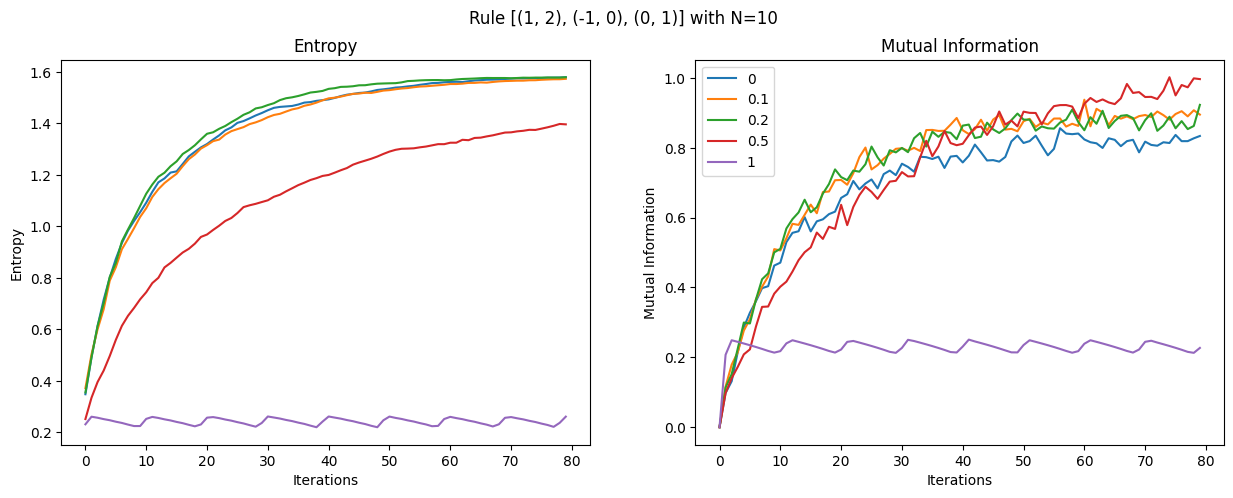

<Figure size 640x480 with 0 Axes>

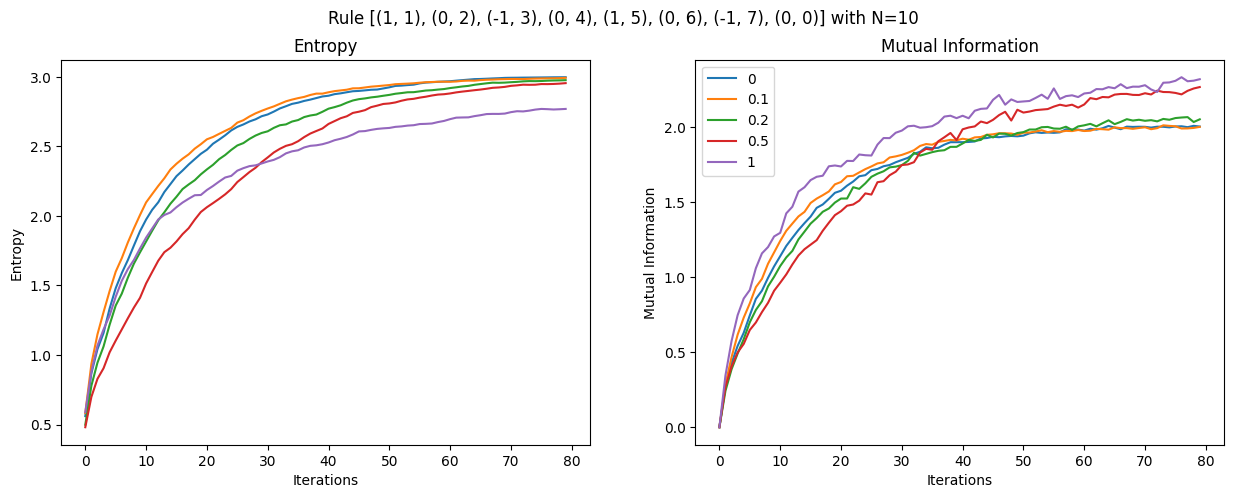

<Figure size 640x480 with 0 Axes>

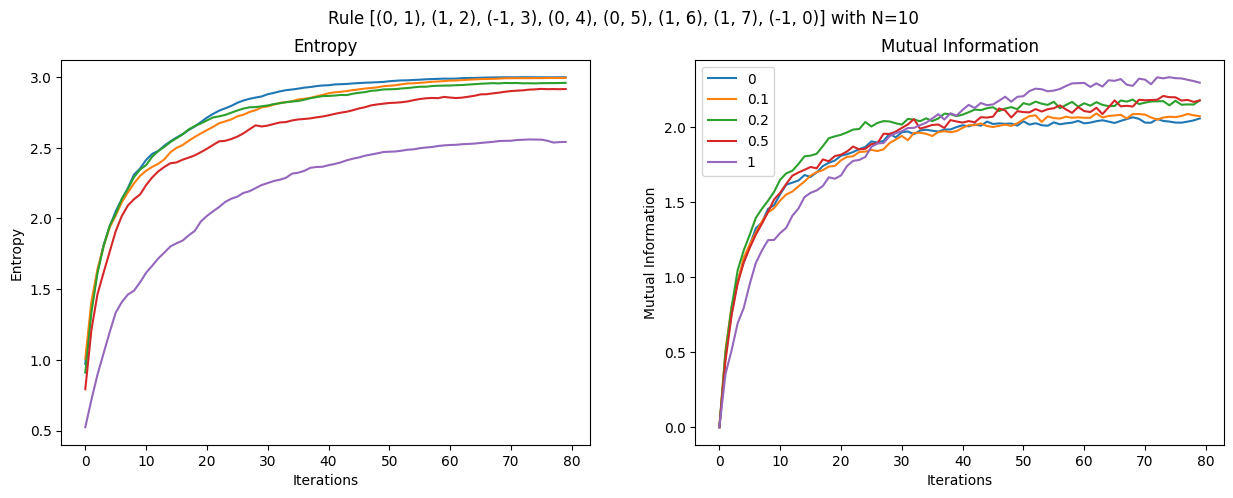

<Figure size 640x480 with 0 Axes>

In [13]:
#finally do it for each of the values of CHAOS_ANTS_SETS
temp_ent  =[]
temp_elem = []
temp_mut  = []

for c in CHAOS_ANTS_SETS:
    entropies, element_sums, mutual_info = get_stats(df, chaos_val = c, n_val=10)
    temp_ent.append(entropies)
    temp_elem.append(element_sums)
    temp_mut.append(mutual_info)

#graph the entropies, element sums, and mutual information for each ruleset, for each of the values of P on the same graph
#we will just graph the basic ruleset for now
for ruleset in range(len(RULESETS)):
    #make entropy, element sums, and mutual information as subplots of one figure
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle("Rule " + str(RULESETS[ruleset]) + " with " + "N=10")
    axs[0].set_title("Entropy")
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel("Entropy")
    for i in range(len(temp_ent)):
        axs[0].plot(temp_ent[i][ruleset])
    axs[1].set_title("Mutual Information")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel("Mutual Information")
    for i in range(len(temp_mut)):
        axs[1].plot(temp_mut[i][ruleset])
    # plt.savefig("rule" + str(RULESETS[ruleset]) + "all.png")
    #add a legend for each of the values of P
    plt.legend(CHAOS_ANTS_SETS)
    plt.savefig("rule_" + str(RULESETS[ruleset]) + "_chaosants_all.png")
    plt.show()

